In [27]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from utils.custom_dataset import GTSRBCustomDataset
from models.resnet_model import get_resnet_model, print_model_info
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

In [28]:
BATCH_SIZE = 32
EPOCHS = 10
CSV_PATH = "dataset/Train.csv"
ROOT_DIR = "dataset"

# Fine-tuning strategy
STRATEGY = 'partial_finetune'  # Options: 'classifier_only', 'partial_finetune', 'full_finetune', 'lightweight'

In [29]:
print("Checking files...")
if not os.path.exists(CSV_PATH):
  raise FileNotFoundError(f"CSV file not found: {CSV_PATH}")
if not os.path.exists(ROOT_DIR):
  raise FileNotFoundError(f"Root directory not found: {ROOT_DIR}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Checking files...
Using device: cuda


In [30]:
transform_train = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.RandomRotation(10),
  transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [31]:
print("Creating dataset...")
train_dataset = GTSRBCustomDataset(CSV_PATH, ROOT_DIR, transform=transform_train)
print(f"Dataset size: {len(train_dataset)}")

Creating dataset...
Loading CSV from: dataset/Train.csv
Dataset loaded: 39209 samples
Columns: ['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId', 'Path']
Validating image paths...
✓ Image 1 exists: Train/20/00020_00000_00000.png
✓ Image 2 exists: Train/20/00020_00000_00001.png
✓ Image 3 exists: Train/20/00020_00000_00002.png
✓ Image 4 exists: Train/20/00020_00000_00003.png
✓ Image 5 exists: Train/20/00020_00000_00004.png
✓ Image 6 exists: Train/20/00020_00000_00005.png
✓ Image 7 exists: Train/20/00020_00000_00006.png
✓ Image 8 exists: Train/20/00020_00000_00007.png
✓ Image 9 exists: Train/20/00020_00000_00008.png
✓ Image 10 exists: Train/20/00020_00000_00009.png
Dataset size: 39209


Testing dataset loading...
Sample loaded successfully - Image shape: torch.Size([3, 224, 224]), Label: 20


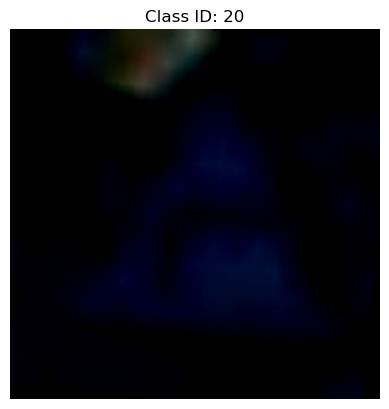

In [32]:
print("Testing dataset loading...")
try:
  sample_image, sample_label = train_dataset[0]
  print(f"Sample loaded successfully - Image shape: {sample_image.shape}, Label: {sample_label}")
  
  image_np = sample_image.permute(1, 2, 0).numpy()
  image_np = (image_np * 0.5 + 0.5).clip(0, 1)

  plt.imshow(image_np)
  plt.title(f"Class ID: {sample_label}")
  plt.axis('off')
  plt.show()

except Exception as e:
  print(f"Error loading sample: {e}")
  exit(1)

In [33]:
train_loader = DataLoader(
  train_dataset, 
  batch_size=BATCH_SIZE, 
  shuffle=True, 
  num_workers=0,
  pin_memory=True if device.type == 'cuda' else False,
  drop_last=True
)

In [34]:
print(f"Loading ResNet model with strategy: {STRATEGY}")
try:
  model = get_resnet_model(num_classes=43, strategy=STRATEGY).to(device)
  print("ResNet model loaded successfully")
  
  print_model_info(model)
    
except Exception as e:
  print(f"Error loading model: {e}")
  exit(1)

Loading ResNet model with strategy: partial_finetune
ResNet model loaded successfully
Model Information:
Total parameters: 11,347,051
Trainable parameters: 10,663,979
Frozen parameters: 683,072
Trainable ratio: 93.98%


In [35]:
criterion = nn.CrossEntropyLoss()

if STRATEGY == 'classifier_only':
  optimizer = optim.Adam(
    [param for param in model.parameters() if param.requires_grad], 
    lr=1e-3, 
    weight_decay=1e-4
  )
    
elif STRATEGY == 'partial_finetune':
  optimizer = optim.Adam([
    {'params': [p for n, p in model.named_parameters() if 'layer3' in n and p.requires_grad], 'lr': 1e-5},
    {'params': [p for n, p in model.named_parameters() if 'layer4' in n and p.requires_grad], 'lr': 1e-5},
    {'params': [p for n, p in model.named_parameters() if 'fc' in n and p.requires_grad], 'lr': 1e-3}
  ], weight_decay=1e-4)
    
elif STRATEGY in ['full_finetune', 'lightweight']:
  optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

In [36]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
  optimizer, mode='max', factor=0.5, patience=3
)

In [37]:
os.makedirs("outputs/checkpoints", exist_ok=True)

In [38]:
best_acc = 0.0
patience_counter = 0
max_patience = 5

In [39]:
print(f"Starting ResNet training...")
print(f"Strategy: {STRATEGY}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Total batches per epoch: {len(train_loader)}")
print(f"Epochs: {EPOCHS}")

for epoch in range(EPOCHS):
  model.train()
  total_loss = 0
  correct = 0
  batch_count = 0

  print(f"\n--- Epoch {epoch+1}/{EPOCHS} ---")

  progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}", ncols=100)

  for batch_idx, (images, labels) in progress_bar:
    try:
      images, labels = images.to(device), labels.to(device)

      # Forward pass
      outputs = model(images)
      loss = criterion(outputs, labels)

      # Backward pass
      optimizer.zero_grad()
      loss.backward()

      # Gradient clipping
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

      optimizer.step()

      total_loss += loss.item()
      correct += (outputs.argmax(1) == labels).sum().item()
      batch_count += 1

      current_acc = correct / ((batch_idx + 1) * BATCH_SIZE)
      progress_bar.set_postfix(loss=loss.item(), acc=current_acc)

    except Exception as e:
      print(f"Error in batch {batch_idx}: {e}")
      continue

  # Stats
  if batch_count > 0:
    avg_loss = total_loss / batch_count
    epoch_acc = correct / len(train_dataset)

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f} - Acc: {epoch_acc:.4f}")

    # Scheduler step
    scheduler.step(epoch_acc)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Learning rate: {current_lr:.6f}")

    # Save best model
    if epoch_acc > best_acc:
      best_acc = epoch_acc
      patience_counter = 0
      torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'accuracy': best_acc,
        'strategy': STRATEGY
      }, f"outputs/checkpoints/resnet18_best_{STRATEGY}.pth")
      print(f"New best accuracy: {best_acc:.4f} - Model saved")
    else:
      patience_counter += 1

    # Early stopping
    if patience_counter >= max_patience:
      print(f"Early stopping triggered. No improvement for {max_patience} epochs.")
      break

  else:
    print(f"Epoch {epoch+1}/{EPOCHS} - No valid batches processed")

Starting ResNet training...
Strategy: partial_finetune
Batch size: 32
Total batches per epoch: 1225
Epochs: 10

--- Epoch 1/10 ---


Epoch 1: 100%|███████████████████████████| 1225/1225 [02:14<00:00,  9.11it/s, acc=0.803, loss=0.198]


Epoch 1/10 - Loss: 0.7132 - Acc: 0.8026
Learning rate: 0.000010
New best accuracy: 0.8026 - Model saved

--- Epoch 2/10 ---


Epoch 2: 100%|█████████████████████████████| 1225/1225 [02:14<00:00,  9.09it/s, acc=0.963, loss=0.3]


Epoch 2/10 - Loss: 0.1296 - Acc: 0.9627
Learning rate: 0.000010
New best accuracy: 0.9627 - Model saved

--- Epoch 3/10 ---


Epoch 3: 100%|████████████████████████████| 1225/1225 [02:16<00:00,  8.95it/s, acc=0.98, loss=0.111]


Epoch 3/10 - Loss: 0.0670 - Acc: 0.9802
Learning rate: 0.000010
New best accuracy: 0.9802 - Model saved

--- Epoch 4/10 ---


Epoch 4: 100%|██████████████████████████| 1225/1225 [03:06<00:00,  6.55it/s, acc=0.988, loss=0.0241]


Epoch 4/10 - Loss: 0.0421 - Acc: 0.9881
Learning rate: 0.000010
New best accuracy: 0.9881 - Model saved

--- Epoch 5/10 ---


Epoch 5: 100%|█████████████████████████| 1225/1225 [03:06<00:00,  6.58it/s, acc=0.993, loss=0.00391]


Epoch 5/10 - Loss: 0.0258 - Acc: 0.9930
Learning rate: 0.000010
New best accuracy: 0.9930 - Model saved

--- Epoch 6/10 ---


Epoch 6: 100%|████████████████████████| 1225/1225 [02:16<00:00,  8.96it/s, acc=0.995, loss=0.000578]


Epoch 6/10 - Loss: 0.0196 - Acc: 0.9943
Learning rate: 0.000010
New best accuracy: 0.9943 - Model saved

--- Epoch 7/10 ---


Epoch 7: 100%|█████████████████████████| 1225/1225 [02:17<00:00,  8.92it/s, acc=0.996, loss=0.00142]


Epoch 7/10 - Loss: 0.0161 - Acc: 0.9957
Learning rate: 0.000010
New best accuracy: 0.9957 - Model saved

--- Epoch 8/10 ---


Epoch 8: 100%|██████████████████████████| 1225/1225 [02:16<00:00,  8.99it/s, acc=0.997, loss=0.0168]


Epoch 8/10 - Loss: 0.0115 - Acc: 0.9968
Learning rate: 0.000010
New best accuracy: 0.9968 - Model saved

--- Epoch 9/10 ---


Epoch 9: 100%|██████████████████████████| 1225/1225 [02:17<00:00,  8.91it/s, acc=0.998, loss=0.0208]


Epoch 9/10 - Loss: 0.0102 - Acc: 0.9973
Learning rate: 0.000010
New best accuracy: 0.9973 - Model saved

--- Epoch 10/10 ---


Epoch 10: 100%|█████████████████████████| 1225/1225 [02:15<00:00,  9.05it/s, acc=0.998, loss=0.0127]


Epoch 10/10 - Loss: 0.0084 - Acc: 0.9979
Learning rate: 0.000010
New best accuracy: 0.9979 - Model saved


In [40]:
print("\nSaving final model...")
torch.save({
  'epoch': epoch,
  'model_state_dict': model.state_dict(),
  'optimizer_state_dict': optimizer.state_dict(),
  'accuracy': epoch_acc if 'epoch_acc' in locals() else 0,
  'strategy': STRATEGY
}, f"outputs/checkpoints/resnet18_final_{STRATEGY}.pth")


Saving final model...


In [41]:
print(f"ResNet Model saved at outputs/checkpoints/resnet18_final_{STRATEGY}.pth")
print(f"Best Model saved at outputs/checkpoints/resnet18_best_{STRATEGY}.pth")

print(f"\nTraining completed!")
print(f"Best accuracy achieved: {best_acc:.4f}")
print(f"Strategy used: {STRATEGY}")
print(f"Total epochs completed: {epoch + 1}")
print(f"Final learning rate: {optimizer.param_groups[0]['lr']:.6f}")

ResNet Model saved at outputs/checkpoints/resnet18_final_partial_finetune.pth
Best Model saved at outputs/checkpoints/resnet18_best_partial_finetune.pth

Training completed!
Best accuracy achieved: 0.9979
Strategy used: partial_finetune
Total epochs completed: 10
Final learning rate: 0.000010
